In [1]:
import json
import websockets, asyncio
import threading

class WaitableQueue(asyncio.Queue):
    def __init__(self):
        super().__init__()
        self.event = threading.Event()

    def put(self, item):
        super().put_nowait(item)
        self.event.set()

    def get(self,timeout=3):
        if self.event.wait(timeout):
            res = super().get_nowait()
            if super().empty():
                self.event.clear()
            return res
        else:
            raise TimeoutError("Environement is not responding.")

# the server
class Server:
    def __init__(self):
        self.inQueue = WaitableQueue()
        self.outQueue = WaitableQueue()
        self.debug = True
        self.ws = None

    def start(self):
        threading.Thread(target=self.message_sender_loop).start()
        asyncio.run(self.main())

    async def main(self):
        try:
            async with websockets.serve(self.echo, "localhost", 8765):
                await asyncio.Future()  # run forever
        except websockets.exceptions.ConnectionClosedError as e: print(e)

    async def echo(self,websocket):
        self.ws = websocket
        print('connect')
        #asyncio.create_task(self.message_sender_loop())
        async for message in websocket:
            try:
                self.recv(json.loads(message))
            except json.decoder.JSONDecodeError:
                self.recv(message)

    def recv(self,message):
        self.inQueue.put(message)
        if self.debug:
            print("recv: ",message)
    
    def send(self,command:str, content):
        self.outQueue.put({'command':command,'content':content})

    def message_sender_loop(self):
        while True:
            try:
                message = self.outQueue.get(None)
                asyncio.run(self.ws.send(json.dumps(message, indent=4)))
            except websockets.exceptions.ConnectionClosedError:
                print("Connection closed")
                break
            except Exception as e:
                print(e)
                break

# start the server in a separate thread to avoid blocking
import threading
server = Server()
t=threading.Thread(target=server.start)
t.start()

# the interface to the server
class WSManager:
    def __init__(self,server:Server):
        self.debug = False
        self.server = server

#server.send("action",{"voltage":[1,0,0,0,100,200,100,100]})

connect
recv:  {'command': 'state', 'content': {'baseLinkPos': {'x': 0.0, 'y': 0.0}, 'baseLinkOrientation': 0.0, 'baseLinkVelocity': {'x': 0.0, 'y': 0.0}, 'baseLinkAngularVelocity': 0.0, 'wheelBaseOrientation': [0.0, 0.0, 0.0, 0.0], 'wheelSpeed': [0.0, 0.0, 0.0, 0.0]}}


In [2]:
import numpy as np
import torch
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list(list_of_lists)
    if hasattr(list_of_lists[0], '__iter__'):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list(list_of_lists[:1]) + flatten(list_of_lists[1:])
def decomposeCosSin(angle):
    return [np.cos(angle), np.sin(angle)]
def processFeature(state:dict,targetPos):
    feature = []
    feature.append(state['baseLinkPos']['x']-targetPos[0].item())
    feature.append(state['baseLinkPos']['y']-targetPos[1].item())
    feature.append(decomposeCosSin(state['baseLinkOrientation']))
    feature.append(state['baseLinkVelocity']['x'])
    feature.append(state['baseLinkVelocity']['y'])
    feature.append(state['baseLinkAngularVelocity'])
    feature.append(decomposeCosSin(state['wheelBaseOrientation']))
    feature.append(state['wheelSpeed'])
    feature = flatten(feature)
    return feature

In [43]:
from torch import nn
class Q(nn.Module):
    def __init__(self,state_size,action_size,hidden_size):
        super(Q, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.fc = nn.Sequential(
        nn.Linear(state_size+action_size,hidden_size),
        nn.LeakyReLU(),
        nn.Linear(hidden_size,hidden_size),
        nn.LeakyReLU(),
        nn.Linear(hidden_size,1)
        )

    def forward(self,state,action):
        return self.fc(torch.cat([state,action],dim=1))

class Policy(nn.Module):
    def __init__(self,state_size,action_size,hidden_size):
        super(Policy, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.fc = nn.Sequential(
        nn.Linear(state_size,hidden_size),
        nn.LeakyReLU(),
        nn.Linear(hidden_size,hidden_size),
        nn.LeakyReLU(),
        nn.Linear(hidden_size,action_size)
        )

    def forward(self,state):
        return self.fc(state)

import random, ou
class Environment:
    def __init__(self,ws_server : Server,device = 'cpu'):
        self.ws = ws_server
        self.replayBuffer = []
        self.t = 0
        self.t_episode = 0
        self.device = device
        self.prevState = None
        self.prevAction = None
        self.pos = None
        self.targetPos = None
        self.ouNoise = ou.ND_OUNoise(8,0, 0.1, 0.2, 0, 100)
        self.noiseIntensity = 0.5

    def restartEpisode(self):
        self.targetPos = self.pos + torch.tensor([0.,-3.])
        self.t_episode = 0
        self.prevState = None
        self.ws.send("new target",{"pos":{'x':self.targetPos[0].item(),'y':0, 'z':self.targetPos[1].item()}})

    def calculateReward(self,pos,targetPos):
        return -torch.dist(pos,targetPos)

    def terminateCondition(self,pos,targetPos):
        return torch.dist(pos,targetPos)<0.5 or torch.dist(pos,targetPos)>10

    def getPos(self,state):
        return torch.tensor([state['baseLinkPos']['x'],state['baseLinkPos']['y']],dtype=torch.float32,device=self.device)

    def update(self, policy: torch.nn.Module):
        raw_state = None
        while not server.inQueue.empty():
            message = server.inQueue.get()
            if message['command'] == 'state':
                raw_state = message['content']
        if raw_state:
            # If the environment returns a state, the step is finnished.
            self.pos = self.getPos(raw_state)
            if self.t_episode > 100 or self.t == 0 or self.terminateCondition(self.pos,self.targetPos):
                self.restartEpisode()
            state = torch.tensor(processFeature(raw_state,self.targetPos),dtype=torch.float32).to(self.device)
                
            # Add the experience to the replay buffer.
            if self.t_episode > 0: # Skip the first step.
                reward = self.calculateReward(self.pos,self.targetPos)- self.calculateReward(self.prevPos,self.targetPos)-(torch.max(torch.zeros_like(self.prevAction),(torch.abs(self.prevAction)-2000))**2).mean()*0.001
                self.replayBuffer.append((state,self.prevAction,reward,self.prevState))
                if len(self.replayBuffer) > 5000:
                    self.replayBuffer.pop(random.randint(0,len(self.replayBuffer)-1))
            
            # Give the new action to enable the environment to continue on the next step.
            with torch.no_grad():
                policy.eval()
                action = policy(state).detach()
                action += self.ouNoise.__next__()*self.noiseIntensity
                #action[5]=action[6]=action[7]=action[4]
                action = torch.clamp(action,-4000,4000)
            self.ws.send("action",{"voltage":list(action.detach().numpy().tolist())})

            
            self.t+=1
            self.t_episode += 1
            self.prevState = state
            self.prevAction = action
            self.prevPos = self.getPos(raw_state)

    def sampleExperience(self,batch_size):
        ns,a,r,s = zip(*random.sample(self.replayBuffer,batch_size))
        return torch.stack(ns),torch.stack(a),torch.stack(r),torch.stack(s)
#env = Environment(server,device)


In [44]:
device = 'cpu'
env = Environment(server,device)
tau = 0.001
gamma = 0.9
batch_size = 128
q = Q(state_size=19,action_size=8,hidden_size=512)
q_target = Q(state_size=19,action_size=8,hidden_size=512)
policy = Policy(state_size=19,action_size=8,hidden_size=512)
policy_target = Policy(state_size=19,action_size=8,hidden_size=512)

In [45]:
optimQ = torch.optim.Adam(q.parameters(),lr=0.001)
optimPolicy = torch.optim.Adam(policy.parameters(),lr=0.0001)

In [47]:
from torch.nn import functional as F
def soft_update_target(target:nn.Module, source:nn.Module,tau):
    for t, s in zip(target.parameters(), source.parameters()):
        t.data.copy_(
            (1. - tau) * t.data + tau * s.data)

server.debug = False
q.train()
policy.train()
q_target.eval()
policy_target.eval()

policy_loss = torch.tensor(torch.nan)

import time
# Fill the replay buffer with random experiences.
while len(env.replayBuffer) < batch_size+1:
    env.update(policy)
    time.sleep(0.02)

# Training.
for t in range(100000000):
    env.update(policy)
    new_state, action, reward, old_state = env.sampleExperience(batch_size)
    q_target.eval()
    policy_target.eval()
    
    with torch.no_grad():
        action = policy_target(new_state)
        torch.clamp(action,-4000,4000)
        new_value = q_target(new_state,action).detach()
        target_value = reward.unsqueeze(1) + gamma*new_value
    
    #target_value = reward.unsqueeze(1)
    q.train()
    policy.train()

    # Update the Q network.
    q_loss = F.mse_loss(q(old_state,action),target_value)
    optimQ.zero_grad()
    q_loss.backward()
    optimQ.step()
    
    if q_loss.item()<50:
        # Update the policy network.
        q.eval()
        action = policy(old_state)
        voltage_penalty = (torch.max(torch.zeros_like(action),(torch.abs(action)-2000))**2).mean()*0.001
        policy_loss = -q(old_state,action).mean() + voltage_penalty
        optimPolicy.zero_grad()
        policy_loss.backward()
        optimPolicy.step()
    
    # Update the target networks.
    soft_update_target(q_target,q,tau)
    soft_update_target(policy_target,policy,tau)
    
    if t % 1000 == 0:
        print(f"q loss: {q_loss.item()}, policy loss: {policy_loss.item()}")
    


q loss: 0.036199960857629776, policy loss: 0.41148167848587036
q loss: 115.41677856445312, policy loss: 5.371466159820557
q loss: 59.23878860473633, policy loss: -1336.0196533203125
q loss: 163.5888671875, policy loss: -694.7199096679688
q loss: 379.21490478515625, policy loss: -2032.822265625
q loss: 163.1428680419922, policy loss: -4514.5078125
q loss: 70.9324951171875, policy loss: -7697.92578125
q loss: 108.2510986328125, policy loss: -12224.8046875
q loss: 444.9300537109375, policy loss: -12224.8046875
q loss: 121.77161407470703, policy loss: -9823.3134765625
q loss: 275.965087890625, policy loss: -9823.3134765625
q loss: 490.2275695800781, policy loss: -9823.3134765625
q loss: 196.96826171875, policy loss: -9823.3134765625
q loss: 103.11354064941406, policy loss: -9823.3134765625
q loss: 414.4934387207031, policy loss: -9823.3134765625
q loss: 491.8260192871094, policy loss: -9823.3134765625
q loss: 571.7609252929688, policy loss: -9823.3134765625
q loss: 857.251953125, policy lo

In [46]:
env.noiseIntensity = 5


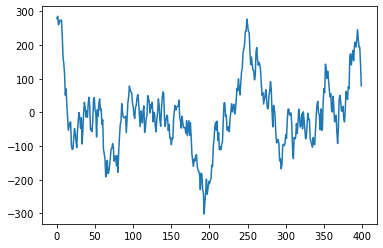

In [63]:
import matplotlib.pyplot as plt
env.ouNoise=ou.ND_OUNoise(8,0, 0.1, 0.2, 0, 100)
a = [x.__next__()[0] for _ in range(400)]                                           
plt.plot(a)

In [24]:
a

[tensor(-9.5670, dtype=torch.float64),
 tensor(9.8081, dtype=torch.float64),
 tensor(5.3224, dtype=torch.float64),
 tensor(74.7011, dtype=torch.float64),
 tensor(100.6852, dtype=torch.float64),
 tensor(129.5651, dtype=torch.float64),
 tensor(109.6969, dtype=torch.float64),
 tensor(57.3070, dtype=torch.float64),
 tensor(93.2750, dtype=torch.float64),
 tensor(72.8083, dtype=torch.float64),
 tensor(3.2205, dtype=torch.float64),
 tensor(6.4383, dtype=torch.float64),
 tensor(4.4081, dtype=torch.float64),
 tensor(49.5963, dtype=torch.float64),
 tensor(75.8122, dtype=torch.float64),
 tensor(63.9655, dtype=torch.float64),
 tensor(91.8483, dtype=torch.float64),
 tensor(60.0776, dtype=torch.float64),
 tensor(52.7905, dtype=torch.float64),
 tensor(-28.2733, dtype=torch.float64),
 tensor(-26.2673, dtype=torch.float64),
 tensor(-24.4788, dtype=torch.float64),
 tensor(-107.4064, dtype=torch.float64),
 tensor(-125.1523, dtype=torch.float64),
 tensor(-144.3442, dtype=torch.float64),
 tensor(-149.0978,

In [28]:
env.pos

tensor([ 4.5314, -0.0419])

connection handler failed
Traceback (most recent call last):
  File "c:\Users\a931e\Anaconda3\envs\nn\lib\site-packages\websockets\legacy\protocol.py", line 944, in transfer_data
    message = await self.read_message()
  File "c:\Users\a931e\Anaconda3\envs\nn\lib\site-packages\websockets\legacy\protocol.py", line 1013, in read_message
    frame = await self.read_data_frame(max_size=self.max_size)
  File "c:\Users\a931e\Anaconda3\envs\nn\lib\site-packages\websockets\legacy\protocol.py", line 1089, in read_data_frame
    frame = await self.read_frame(max_size)
  File "c:\Users\a931e\Anaconda3\envs\nn\lib\site-packages\websockets\legacy\protocol.py", line 1144, in read_frame
    frame = await Frame.read(
  File "c:\Users\a931e\Anaconda3\envs\nn\lib\site-packages\websockets\legacy\framing.py", line 70, in read
    data = await reader(2)
  File "c:\Users\a931e\Anaconda3\envs\nn\lib\asyncio\streams.py", line 721, in readexactly
    raise exceptions.IncompleteReadError(incomplete, n)
asyncio.

connect


In [16]:
server.outQueue

<WaitableQueue at 0x131ce69a580 maxsize=0 _queue=[{'command': 'action', 'content': {'voltage': [0, 0, 0, 0, 0, 0, 0, 0]}}, {'command': 'action', 'content': {'voltage': [0, 0, 0, 0, 0, 0, 0, 0]}}, {'command': 'action', 'content': {'voltage': [0, 0, 0, 0, 0, 0, 0, 0]}}, {'command': 'action', 'content': {'voltage': [0, 0, 0, 0, 0, 0, 0, 0]}}, {'command': 'action', 'content': {'voltage': [0, 0, 0, 0, 0, 0, 0, 0]}}, {'command': 'action', 'content': {'voltage': [0, 0, 0, 0, 0, 0, 0, 0]}}, {'command': 'action', 'content': {'voltage': [0, 0, 0, 0, 0, 0, 0, 0]}}] tasks=8>